In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

In [2]:
# Load your dataset
# Assuming your data is in a pandas dataframe called 'df'
# 'target' is the column with the disease classification (1 or 0)
df = pd.read_csv('/kaggle/input/imlcomp1/train_set.csv')
X = df.drop('Y', axis=1)
y = df['Y']

In [3]:
X

,RecordId,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X69,X70,X71,X72,X73,X74,X75,X76,X77,X78
0,1,87.000000,34.118411,0,2,0,165.100000,1,829,2,...,0.110000,0.040000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
1,2,82.372284,31.573280,0,0,1,162.983897,1,724,0,...,0.100292,0.033431,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
2,3,50.000000,27.771653,0,0,1,165.100000,1,895,2,...,0.020000,0.010000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
3,4,66.236109,26.515922,0,0,1,167.009549,1,637,0,...,0.108249,0.039363,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
4,5,81.303299,20.843691,0,0,1,158.165419,0,564,0,...,0.164645,0.069242,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246117,246118,65.149110,33.357948,0,0,1,156.317941,1,711,0,...,0.088610,0.027152,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
246118,246119,48.000000,46.736176,0,0,1,157.000000,1,594,2,...,-1.000000,0.560000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
246119,246120,57.472080,41.854115,1,0,0,189.868698,2,455,0,...,0.032961,0.020601,0.0,0.0,0.587987,0.0,0.412013,0.0,0.0,0.412013
246120,246121,66.000000,23.738662,1,0,1,168.000000,2,609,0,...,0.020000,-1.000000,0.0,0.0,1.000000,0.0,0.000000,0.0,0.0,0.000000


In [4]:
y

0         0
1         0
2         0
3         0
4         0
         ..
246117    0
246118    1
246119    0
246120    0
246121    0
Name: Y, Length: 246122, dtype: int64

In [5]:
dfX_filled = X.fillna(X.mean())
dfY_filled = y.fillna(y.mean())
df_filled = df.fillna(df.mean())

In [6]:
# Calculate the number of true positives and true negatives
true_positive_count = (df_filled['Y'] == 1).sum()  # Count of true positives
true_negative_count = (df_filled['Y'] == 0).sum()  # Count of true negatives

# Display the results
print(f"True Positive Count: {true_positive_count}")
print(f"True Negative Count: {true_negative_count}")

True Positive Count: 649
True Negative Count: 245473


In [7]:
# Separate the positive and negative instances
df_positive = df_filled[df_filled['Y'] == 1]
df_negative = df_filled[df_filled['Y'] == 0]

# Calculate how many more positive instances are needed
needed_positive_count = true_negative_count - true_positive_count

# Upscale positive instances by sampling with replacement
if needed_positive_count > 0:
    df_positive_upscaled = df_positive.sample(n=needed_positive_count, replace=True, random_state=42)
else:
    df_positive_upscaled = pd.DataFrame()  # No upscaling needed if positive count is already equal to or greater

# Combine the original positive instances with the upscaled ones
df_balanced = pd.concat([df_positive, df_positive_upscaled, df_negative])

# Shuffle the resulting DataFrame (optional)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the balanced DataFrame
print("Balanced DataFrame:")
print(df_balanced)
print(f"New Positive Count: {(df_balanced['Y'] == 1).sum()}")
print(f"New Negative Count: {(df_balanced['Y'] == 0).sum()}")

Balanced DataFrame:
        RecordId         X2         X3  X4  X5  X6          X7  X8   X9  X10  \
0          60473  67.000000  23.623079   0   0   1  157.500000   1  822    0   
1         225680  67.000000  31.577096   1   0   1  168.010091   2  470    0   
2         121759  71.594325  35.217679   0   3   1  168.807136   1  663    0   
3          14588  68.090962  29.920817   0   0   1  156.491078   1  830    0   
4         241781  67.000000  25.598388   0   0   1  157.500000   1  259    0   
...          ...        ...        ...  ..  ..  ..         ...  ..  ...  ...   
490941     13747  49.000000  37.453136   0   0   0  177.800000   1   98    0   
490942    120664  72.000000  27.168341   0   3   0  182.975299   0  573    0   
490943    144618  65.000000  22.714688   0   0   0  170.200000   1  687    0   
490944     67723  75.000000  22.674673   0   0   0  175.200000   1  388    0   
490945    110725  71.000000  26.573129   0   0   1  168.000000   1  376    0   

        ...       X

In [8]:
df = df_balanced

In [9]:
X = df.drop('Y', axis=1)
y = df['Y']

In [10]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
pipeline = Pipeline([
    ('var_thresh', VarianceThreshold(threshold=0.1)),  # Remove features with low variance
    ('k_best', SelectKBest(score_func=f_classif, k=20)),  # Select top 20 features
    ('xgb', XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42))
])

In [12]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('var_thresh', VarianceThreshold(threshold=0.1)),
                ('k_best', SelectKBest(k=20)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [13]:
# Make predictions
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Probability estimates for ROC-AUC

Accuracy: 0.952683251405448
Confusion Matrix:
[[68029  5609]
 [ 1360 72286]]
              precision    recall  f1-score   support

           0       0.98      0.92      0.95     73638
           1       0.93      0.98      0.95     73646

    accuracy                           0.95    147284
   macro avg       0.95      0.95      0.95    147284
weighted avg       0.95      0.95      0.95    147284

AUC of ROC: 0.987117556145771


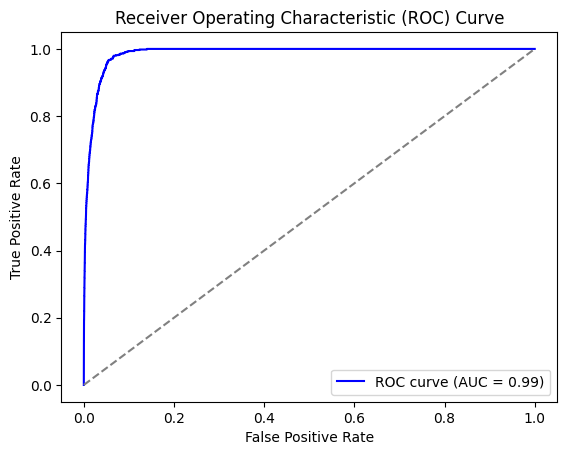

In [14]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Calculate AUC of ROC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("AUC of ROC:", roc_auc)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [15]:
df_test = pd.read_csv('/kaggle/input/imlcomp1/test_set.csv')

In [16]:
df_test_filled = df_test.fillna(df_test.mean())

In [17]:
# Make predictions
y_pred = pipeline.predict(df_test_filled)
y_pred_proba = pipeline.predict_proba(df_test_filled)[:, 1]  # Probability estimates for ROC-AUC

In [18]:
# Save the test predictions (if needed)
df_test_filled['Y'] = y_pred
df_test_filled[['RecordId', 'Y']].to_csv('test_predictions.csv', index=False)

print("Predictions made on the test set and saved to 'test_predictions.csv'.")

Predictions made on the test set and saved to 'test_predictions.csv'.
